In [1]:
import pandas as pd 
import numpy as np
import math
import keras
import tensorflow as tf
import progressbar
import os
from os import listdir
from matplotlib import pyplot as plt
import imblearn
from imblearn.under_sampling import RandomUnderSampler

## Print Dependencies


Dependences are fundamental to record the computational environment.

In [2]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p pandas,keras,numpy,math,tensorflow,matplotlib,h5py,imblearn

# date
print (" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.26.0

pandas    : 1.2.3
keras     : 2.4.3
numpy     : None
math      : unknown
tensorflow: 2.5.0
matplotlib: 3.4.2
h5py      : 3.1.0
imblearn  : 0.8.1

Compiler    : Clang 12.0.0 (clang-1200.0.32.29)
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

 
Last updated: Thu Jul 14 2022 11:15:17WEST



## Some useful functions

In [3]:
def prepare_data(class_data): 
    np.random.shuffle(class_data)
    iX = np.arange(class_data.shape[0])
    np.random.shuffle(iX)
    class_data = class_data[iX]
    #change this value if you want to change the normalization factor of the TCS (to have a better training)
    #but please keep in mind that if you use the sigmoid as the last layer you have to have values between 0 and 1
    #to predict!
    norm = 1e26
    class_data[:,2] *= norm
    y = class_data[:,2]
    x = class_data[:,0:2]
    #the number of columns you take it's going to change depending on the case you have
    train_split = 0.85
    train_limit = int(len(y)*train_split)
    print("Training sample of: {0} \nValuation sample: {1}".format(train_limit, len(y)-train_limit))
    x_train = x[:train_limit]
    x_val = x[train_limit:]
    y_train = y[:train_limit]
    y_val = y[train_limit:]
    if np.isnan(np.min(y)) == False:
        return x_train, y_train, x_val, y_val

In [4]:
def plot_histo(x, y, bins,logscale):
    y = np.array(y)
    plt.hist(y, bins, color = 'indianred', alpha=0.5, label='Osiris')
    plt.legend(loc='upper right')
    plt.xlabel('Probability')
    if logscale == 1:
        plt.yscale('log')
    plt.title('Trained on ($p_e$, $p_{\gamma}$, $\omega_e$, $\omega_{\gamma}$, n)')
    plt.show()

In [5]:
def loaddata(name):
     return np.loadtxt(name, delimiter=',')

In [6]:
def balance_data2(class_data, nbins, ratio):
    y = class_data[:,2]
    n, edges, _ = plt.hist(y, nbins, color = 'indianred', alpha=0.5, label='Osiris')
    n_max = int(n.max())*ratio
    data = []
    bar = progressbar.ProgressBar(maxval=len(class_data), 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                       progressbar.Percentage(), 
                                       " of {0}".format(len(class_data))])
    bar.start()
    cow = 0
    for k, class_ in enumerate(class_data):
        for i in range(len(n)):
            edges_min = edges[i]
            edges_max = edges[i+1]
            if class_[0] > edges_min and class_[0] < edges_max:
                if int(n[i]/n_max) > 1 :
                    step = int(n[i]/n_max)
                    if cow%step==0:
                        data.append(class_)
                    cow +=1
                else:
                    for j in range(int(n_max/(n[i]))):
                        data.append(class_)
        bar.update(k+1)
            
    bar.finish()

    #plt.hist(data, nbins, color = 'indianred', alpha=0.5, label='Osiris')
    
    return np.array(data)

In [7]:
def balance_data(class_data, nbins):
    y = class_data[:,2]
    n, edges, _ = plt.hist(y, nbins, color = 'indianred', alpha=0.5, label='Osiris')
    n_max = int(n.max())
    data = []
    bar = progressbar.ProgressBar(maxval=len(class_data), 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                       progressbar.Percentage(), 
                                       " of {0}".format(len(class_data))])
    bar.start()
    for k, class_ in enumerate(class_data):
        for i in range(len(n)):
            edges_min = edges[i]
            edges_max = edges[i+1]
            if class_[2] >= edges_min and class_[2] <= edges_max:
                for j in range(int((n_max/n[i]))):
                    data.append(class_)
                break
        bar.update(k+1)
    bar.finish()

    return np.array(data)

In [8]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['mape']
    val_accuracy = history.history['val_mape']


    epochs = range(1, len(loss) + 1)
    fig, ax1 = plt.subplots()

    l1 = ax1.plot(epochs, loss, 'bo', label='Training loss')
    vl1 = ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (mae))')

    ax2 = ax1.twinx()
    ac2= ax2.plot(epochs, accuracy, 'o', c="red", label='Training acc')
    vac2= ax2.plot(epochs, val_accuracy, 'r', label='Validation acc')
    ax2.set_ylabel('mape')

    lns = l1 + vl1 + ac2 + vac2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc="center right")
    fig.tight_layout()
    fig.show()

## Our beautiful probability distributions (non balanced)

In [9]:
BH_tcs = loaddata("data_betheheitler/data/{}.csv".format('BH_tcs'))

In [10]:
BH_tcs.shape

(10000, 3)

In [11]:
print(BH_tcs[:,0:1])

[[  1.]
 [  1.]
 [  1.]
 ...
 [100.]
 [100.]
 [100.]]


In [12]:
x0_train, y0_train, x0_val, y0_val = prepare_data(BH_tcs)

Training sample of: 8500 
Valuation sample: 1500


In [13]:
y0_train

array([0.02954367, 0.05492832, 0.21231345, ..., 0.0020226 , 0.00373216,
       0.14915989])

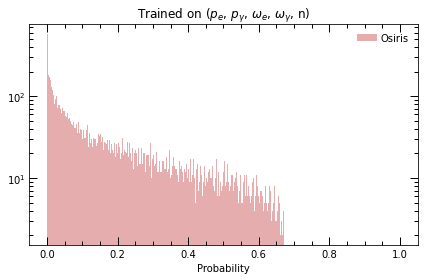

In [23]:
bins = np.linspace(0.000, 1., 500)
plot_histo(x0_train,y0_train,bins,1)

In [15]:
x0_train.shape

(8500, 2)

## Model Build

__1)__ This is the first step in our chaing of Transfer Learning. We have to buil the model that we're going to reuse also in the next trainings. 

In [16]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers
from keras.layers.normalization import BatchNormalization

In [17]:
def build_model() :
    model = models.Sequential()
    model.add (BatchNormalization(input_dim = 2))
    model.add (layers.Dense (2 , activation = "relu"))
    model.add (layers.Dense (2 , activation = "relu"))
    model.add (layers.Dense (1 , activation = "sigmoid"))
    model.compile(optimizer = "adam" , loss = 'mape' , metrics = ["binary_crossentropy","mae"])
    return model

In [18]:
model = build_model ()
history0 = model.fit ( x0_train, y0_train, epochs = 100, batch_size = 32 , validation_data = (x0_val, y0_val) )
model.save("models/{}.h5".format('BH_tcs_pred'))

2022-07-14 11:15:18.763455: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 11:15:18.976603: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
266/266 [==============================] - 12s 3ms/step - loss: 21346.1137 - binary_crossentropy: 0.6831 - mae: 0.3418 - val_loss: 28778.6328 - val_binary_crossentropy: 0.6363 - val_mae: 0.3110
Epoch 2/100
266/266 [==============================] - 0s 1ms/step - loss: 21536.8835 - binary_crossentropy: 0.6071 - mae: 0.2921 - val_loss: 18728.1191 - val_binary_crossentropy: 0.5108 - val_mae: 0.2170
Epoch 3/100
266/266 [==============================] - 0s 1ms/step - loss: 11751.3124 - binary_crossentropy: 0.4944 - mae: 0.1989 - val_loss: 12484.7295 - val_binary_crossentropy: 0.4429 - val_mae: 0.1518
Epoch 4/100
266/266 [==============================] - 0s 1ms/step - loss: 10169.2790 - binary_crossentropy: 0.4436 - mae: 0.1445 - val_loss: 8479.8877 - val_binary_crossentropy: 0.4245 - val_mae: 0.1233
Epoch 5/100
266/266 [==============================] - 0s 1ms/step - loss: 5961.9964 - binary_crossentropy: 0.4405 - mae: 0.1283 - val_loss: 5839.0752 - val_binary_crossentropy: 0.

266/266 [==============================] - 0s 1ms/step - loss: 74.4970 - binary_crossentropy: 0.4140 - mae: 0.0874 - val_loss: 74.2708 - val_binary_crossentropy: 0.4027 - val_mae: 0.0822
Epoch 42/100
266/266 [==============================] - 0s 957us/step - loss: 72.7048 - binary_crossentropy: 0.4070 - mae: 0.0851 - val_loss: 74.0608 - val_binary_crossentropy: 0.4035 - val_mae: 0.0817
Epoch 43/100
266/266 [==============================] - 0s 1ms/step - loss: 70.9575 - binary_crossentropy: 0.4100 - mae: 0.0855 - val_loss: 74.1458 - val_binary_crossentropy: 0.4116 - val_mae: 0.0855
Epoch 44/100
266/266 [==============================] - 0s 1000us/step - loss: 74.3276 - binary_crossentropy: 0.4155 - mae: 0.0880 - val_loss: 71.7563 - val_binary_crossentropy: 0.4070 - val_mae: 0.0843
Epoch 45/100
266/266 [==============================] - 0s 1ms/step - loss: 72.4339 - binary_crossentropy: 0.4202 - mae: 0.0889 - val_loss: 73.5797 - val_binary_crossentropy: 0.4195 - val_mae: 0.0887
Epoch 46

Epoch 82/100
266/266 [==============================] - 0s 919us/step - loss: 69.9587 - binary_crossentropy: 0.4219 - mae: 0.0910 - val_loss: 69.5694 - val_binary_crossentropy: 0.4150 - val_mae: 0.0864
Epoch 83/100
266/266 [==============================] - 0s 992us/step - loss: 69.2134 - binary_crossentropy: 0.4236 - mae: 0.0901 - val_loss: 68.0770 - val_binary_crossentropy: 0.4159 - val_mae: 0.0890
Epoch 84/100
266/266 [==============================] - 0s 917us/step - loss: 70.6865 - binary_crossentropy: 0.4169 - mae: 0.0896 - val_loss: 68.3463 - val_binary_crossentropy: 0.4133 - val_mae: 0.0874
Epoch 85/100
266/266 [==============================] - 0s 943us/step - loss: 69.0089 - binary_crossentropy: 0.4172 - mae: 0.0888 - val_loss: 67.8695 - val_binary_crossentropy: 0.4172 - val_mae: 0.0900
Epoch 86/100
266/266 [==============================] - 0s 938us/step - loss: 68.4004 - binary_crossentropy: 0.4220 - mae: 0.0911 - val_loss: 67.9284 - val_binary_crossentropy: 0.3973 - val_ma

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 2)                 8         
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 23
Trainable params: 19
Non-trainable params: 4
_________________________________________________________________


## Probability density distribution

In [20]:
y_pred0 = model.predict(x0_train)

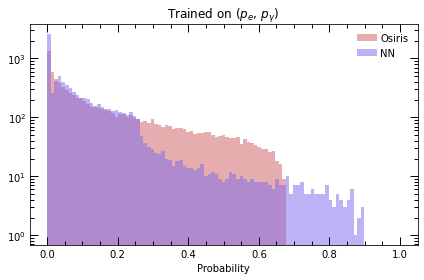

In [22]:
from matplotlib import pyplot
y0_val = np.array(y0_val)
bins = np.linspace(0., 1., 100)
pyplot.hist(y0_train, bins, color = 'indianred', alpha=0.5, label='Osiris')
pyplot.hist(y_pred0, bins, color = 'mediumslateblue', alpha=0.5, label='NN')
pyplot.yscale('log')
pyplot.legend(loc='upper right')
pyplot.xlabel('Probability')
pyplot.title('Trained on ($p_e$, $p_{\gamma}$)')
pyplot.show()